# Processing code of main and exog datasets 

-> index each dataset from 2015Q1 - 2023Q4.   
-> after everything merged, THEN do the COVID subset. 

In [64]:
import pandas as pd 

def quarter_standardize(df, date="Date", month="Month", format_used="%B %Y"):
    df[date] = pd.to_datetime(df[month], format=format_used)
    df["Quarter"] = df[date].dt.to_period("Q").astype(str)
    df = df.sort_values("Date").reset_index(drop=True)
    return df

# Standardizing and getting each file

## baggage dataset


In [65]:
import pandas as pd

df = pd.read_csv(r"/home/rayan/Southwest_stuff/BaggageRevenueModel/combined_bag_revenue.csv")
df.head()

bg_long = df.melt(id_vars=['Airline'], var_name='Quarter', value_name="Baggage Revenue")
bg_long['Quarter'] = pd.PeriodIndex(bg_long['Quarter'], freq='Q').to_timestamp(how="start")
bg_long = bg_long[(bg_long["Quarter"] >= "2015-Q1") & (bg_long["Quarter"] <= "2023-Q3")]
bg_long = bg_long.rename(columns={"Airline": "unique_id", "Baggage Revenue": "y"})

bg_long = bg_long[['unique_id', 'Quarter', 'y']].rename(columns={"Quarter": "ds"})

bg_long.head()

,unique_id,ds,y
0,Alaska,2015-01-01,23686.0
1,Allegiant,2015-01-01,40444.0
2,American,2015-01-01,151758.0
3,Delta,2015-01-01,198119.0
4,Frontier,2015-01-01,42011.0


## jet fuel

In [66]:
jet_fuel = pd.read_csv(r"/home/rayan/Southwest_stuff/BaggageRevenueModel/data/jet_fuel_prices 2000-2023.csv")

jet_fuel = quarter_standardize(jet_fuel, "Date", "Month of Date", "%B %Y")
jet_fuel = jet_fuel[(jet_fuel["Quarter"] >= "2015Q1") & (jet_fuel["Quarter"] <= "2023Q3")]

# Unsure if we care about Diesel type, *maybe* for ground operations. Not a priority. 
jet_fuel = jet_fuel[jet_fuel['Fuel Type'] == "Jet Fuel"]


jet_fuel["Price (cents per gallon)"] = (jet_fuel["Price (cents per gallon)"]
                                        .str.replace("$", "", regex=False)
                                        .astype(float)
                                        )

jet_fuel_q = (jet_fuel.groupby(["Quarter", "Fuel Type"])["Price (cents per gallon)"].mean().reset_index().sort_values(["Fuel Type", "Quarter"]))
jet_fuel_q['Quarter'] = pd.PeriodIndex(jet_fuel_q['Quarter'], freq='Q').to_timestamp(how="start")

# Odd error when renaming both in the same line. Overall logic is still fine, review later. 
jet_fuel_q = jet_fuel_q.rename(columns={"Quarter": "ds"})
jet_fuel_q = jet_fuel_q.rename(columns={"Price (cents per gallon)": "jetfuel_cost"})
jet_fuel_q = jet_fuel_q[["ds", "jetfuel_cost"]]
jet_fuel_q.head()

,ds,jetfuel_cost
0,2015-01-01,163.033333
1,2015-04-01,176.100000
2,2015-07-01,144.433333
3,2015-10-01,126.633333
4,2016-01-01,99.066667


## unemployment data

In [67]:
unemp = pd.read_csv(r"/home/rayan/Southwest_stuff/BaggageRevenueModel/data/US Unemployment Data 2014-2024.csv")
unemp["Month"] = (
    unemp["Month"]
      .str.replace("June", "Jun", regex=False)
      .str.replace("July", "Jul", regex=False)
      .str.replace("Sept", "Sep", regex=False)
)


unemp = quarter_standardize(unemp, format_used="%b %Y")
unemp = unemp[(unemp["Quarter"] >= "2015Q1") & (unemp["Quarter"] <= "2023Q3")]
unemp_q = (unemp.groupby("Quarter").agg({"Total": "mean"}).reset_index())
unemp_q['Quarter'] = pd.PeriodIndex(unemp_q['Quarter'], freq='Q').to_timestamp(how="start")
unemp_q = unemp_q.rename(columns={"Quarter" : "ds", "Total" : "unemployment_rate"})
unemp_q.head()

,ds,unemployment_rate
0,2015-01-01,5.533333
1,2015-04-01,5.433333
2,2015-07-01,5.100000
3,2015-10-01,5.033333
4,2016-01-01,4.900000


## GDP 

In [68]:
gdp_df = pd.read_csv(r"/home/rayan/Southwest_stuff/BaggageRevenueModel/data/GDP_per_capita_1947-2025.csv")
gdp_df = gdp_df.rename(columns={"observation_date" : "Quarter", "A939RX0Q048SBEA" : "GDP"})
gdp_df = gdp_df[(gdp_df["Quarter"] >= "2015-01-01") & (gdp_df["Quarter"] <= "2023-07-01")]
gdp_df['Quarter'] = pd.PeriodIndex(gdp_df['Quarter'], freq='Q').to_timestamp(how="start") # forcing anyway
gdp_df = gdp_df.rename(columns={"Quarter" : "ds"})
gdp_df.head()


,ds,GDP
272,2015-01-01,58121
273,2015-04-01,58376
274,2015-07-01,58486
275,2015-10-01,58470
276,2016-01-01,58704


# Merging

In [69]:
bg_merged = (
    bg_long
        .merge(jet_fuel_q[["ds", "jetfuel_cost"]], on="ds", how="left")
        .merge(unemp_q[["ds", "unemployment_rate"]], on="ds", how="left")
        .merge(gdp_df[["ds", "GDP"]], on="ds", how="left")
)

bg_merged.head()

,unique_id,ds,y,jetfuel_cost,unemployment_rate,GDP
0,Alaska,2015-01-01,23686.0,163.033333,5.533333,58121
1,Allegiant,2015-01-01,40444.0,163.033333,5.533333,58121
2,American,2015-01-01,151758.0,163.033333,5.533333,58121
3,Delta,2015-01-01,198119.0,163.033333,5.533333,58121
4,Frontier,2015-01-01,42011.0,163.033333,5.533333,58121


In [70]:
first_half_end = pd.Timestamp("2019-10-01")
covid_end = pd.Timestamp("2021-04-01")

pre_covid = bg_merged[bg_merged['ds'] <= first_half_end].copy()
post_covid = bg_merged[bg_merged['ds'] > covid_end].copy()

pre_covid_last_period = pre_covid['ds'].max().to_period('Q')
post_covid_first_period = post_covid['ds'].min().to_period('Q')
gap_quarters = (post_covid_first_period - pre_covid_last_period).n

print(f"Num gap quarters offset: {gap_quarters}")

pre_covid['ds'] = pre_covid['ds'] + pd.offsets.QuarterEnd(gap_quarters)

df_reindexed = (
    pd.concat([pre_covid, post_covid])
      .sort_values(['unique_id', 'ds'])
      .drop_duplicates(subset=['unique_id', 'ds'], keep='first')
      .reset_index(drop=True)
)

df_reindexed.head(10)


Num gap quarters offset: 7


,unique_id,ds,y,jetfuel_cost,unemployment_rate,GDP
0,Alaska,2016-09-30,23686.0,163.033333,5.533333,58121
1,Alaska,2016-12-31,30215.0,176.100000,5.433333,58376
2,Alaska,2017-03-31,34127.0,144.433333,5.100000,58486
3,Alaska,2017-06-30,24787.0,126.633333,5.033333,58470
4,Alaska,2017-09-30,30484.0,99.066667,4.900000,58704
5,Alaska,2017-12-31,35022.0,127.600000,4.933333,58787
6,Alaska,2018-03-31,39297.0,129.533333,4.900000,59084
7,Alaska,2018-06-30,30811.0,143.466667,4.766667,59296
8,Alaska,2018-09-30,30602.0,150.200000,4.566667,59494
9,Alaska,2018-12-31,38232.0,140.566667,4.366667,59736


## 


In [ ]:
df_reindexed.to_csv(r"/home/rayan/Southwest_stuff/BaggageRevenueModel/data/combined_bag_rev_exog.csv")

We re read the dataset and plot distributions of different variables. 

In [2]:
import pandas as pd

df_reindexed = pd.read_csv(r"/home/rayan/Southwest_stuff/BaggageRevenueModel/data/combined_bag_rev_exog.csv")

In [3]:
df_reindexed.head()

,Unnamed: 0,unique_id,ds,y,jetfuel_cost,unemployment_rate,GDP
0,0,Alaska,2016-09-30,23686.0,163.033333,5.533333,58121
1,1,Alaska,2016-12-31,30215.0,176.100000,5.433333,58376
2,2,Alaska,2017-03-31,34127.0,144.433333,5.100000,58486
3,3,Alaska,2017-06-30,24787.0,126.633333,5.033333,58470
4,4,Alaska,2017-09-30,30484.0,99.066667,4.900000,58704


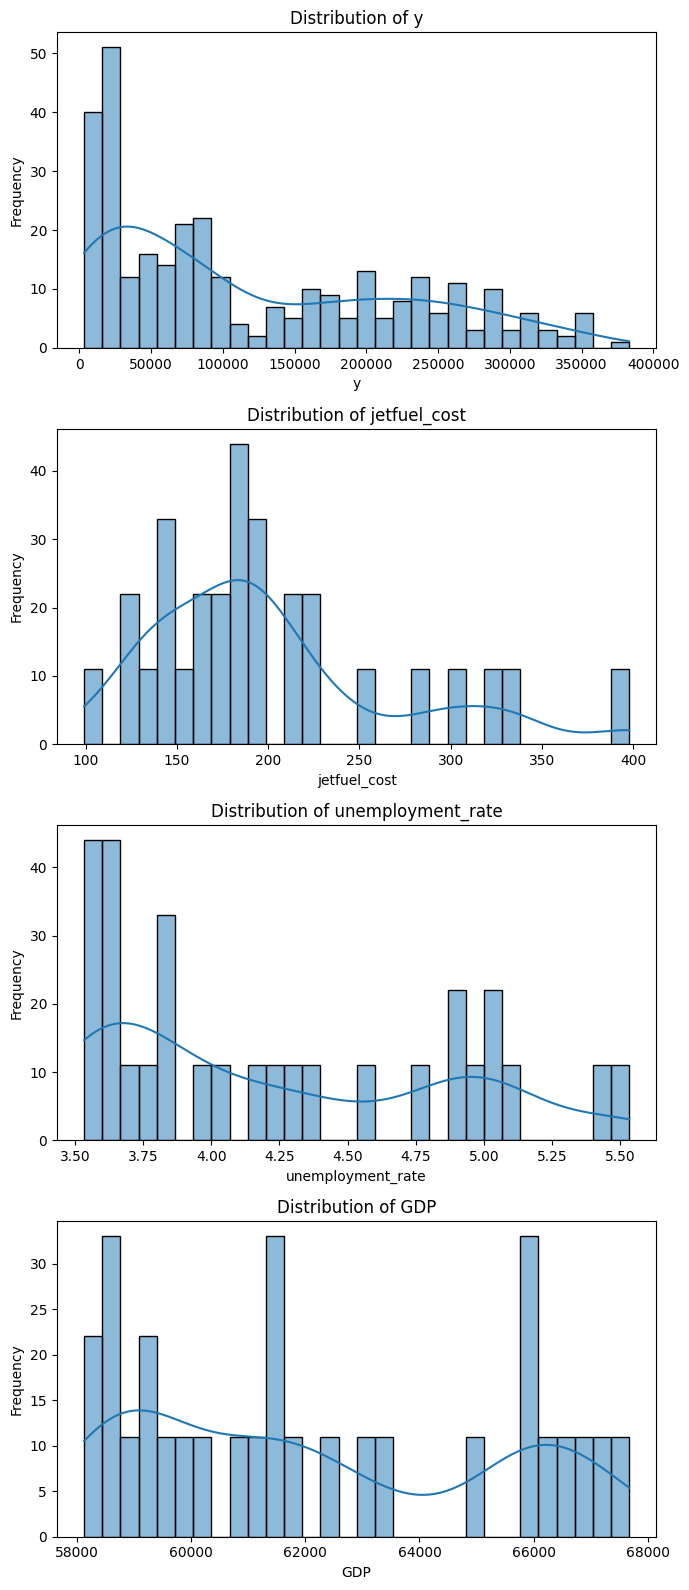

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns 

columns_to_plot = ['y', 'jetfuel_cost', 'unemployment_rate', 'GDP']  

fig, axes = plt.subplots(len(columns_to_plot), 1, figsize=(7, 4 * len(columns_to_plot)))

for i, col in enumerate(columns_to_plot):
    sns.histplot(df_reindexed[col], kde=True, bins=30, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()